##### [this demo requires doom installed either officially or from gym-pool. Or simply use https://github.com/justheuristic/doomed_dqn]

# This tutorial is will bring you through your first deep reinforcement learning model


* Seaquest game as an example
* Training a simple lasagne neural network for Q_learning objective


## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym


## New to Lasagne and AgentNet?
* We only require surface level knowledge of theano and lasagne, so you can just learn them as you go.
* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb
* This is pretty much the basic tutorial for AgentNet, so it's okay not to know it.


# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%env THEANO_FLAGS="device=gpu"

env: THEANO_FLAGS="device=gpu"


In [4]:
from scipy.misc import imresize
#game image will be resized from(96,128) to your image_size. 
#You may want a bigger image for your homework assignment IF you want a larger NN

IMAGE_W,IMAGE_H = IMAGE_SIZE =(60,80)#(96,128)
def preprocess(obs):
    return (imresize(obs,IMAGE_SIZE).mean(-1)/255.)

In [6]:
import gym
import ppaquette_gym_doom
from gym.wrappers import SkipWrapper
from ppaquette_gym_doom.wrappers.action_space import ToDiscrete
GAME_NAME = 'ppaquette/DoomBasic-v0'

make_env = lambda: SkipWrapper(4)(ToDiscrete("minimal")(gym.make(GAME_NAME)))

env = make_env()

[2017-01-14 11:42:08,087] Making new env: ppaquette/DoomBasic-v0


In [8]:
#global params.

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 10

-10.0 False


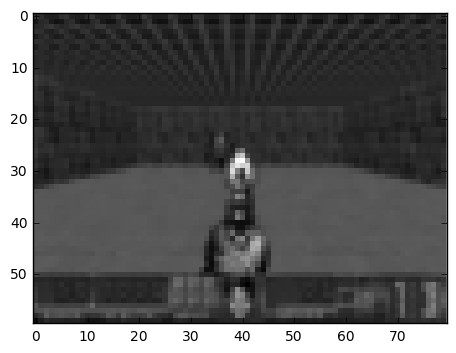

In [9]:
env.reset()
obs,r,done,_=env.step(1)
print r, done
plt.imshow(preprocess(obs),cmap='gray',interpolation='none')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [10]:
import lasagne
from lasagne.layers import *
#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,IMAGE_W,IMAGE_H))

Using gpu device 0: GeForce GTX 1080 (CNMeM is enabled with initial size: 45.0% of memory, cuDNN 5105)


In [12]:
from agentnet.memory import WindowAugmentation,LSTMCell,RNNCell

#store 4-tick window in order to perceive motion of objects

prev_window = InputLayer((None,4,IMAGE_W,IMAGE_H))

current_window = WindowAugmentation(observation_layer,prev_window)

In [13]:
from lasagne.layers import Conv2DLayer,Pool2DLayer,DenseLayer,batch_norm,dropout

#main neural network body
conv0 = Conv2DLayer(current_window,32,filter_size=(8,8),stride=(4,4),name='conv0')

conv1 = Conv2DLayer(batch_norm(conv0),64,filter_size=(4,4),stride=(2,2),name='conv1')

dense0 = DenseLayer(batch_norm(conv1),512,name='dense',nonlinearity = lasagne.nonlinearities.tanh)

#please set this to your last layer for convenience
last_layer = dense0

In [14]:
#a layer that predicts Qvalues
qvalues_layer = DenseLayer(last_layer,
                   num_units = env.action_space.n,
                   nonlinearity=lasagne.nonlinearities.linear,
                   name="q-evaluator layer")

#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer,name="e-greedy action picker")

action_layer.epsilon.set_value(np.float32(0.1))


In [15]:
from agentnet.target_network import TargetNetwork
targetnet = TargetNetwork(qvalues_layer,dense0)


In [16]:
qvalues_old = targetnet.output_layers

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [17]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(qvalues_layer,qvalues_old),
              agent_states={current_window:prev_window},
              action_layers=action_layer)


In [18]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[conv0.W,
 conv0_bn.beta,
 conv0_bn.gamma,
 conv1.W,
 conv1_bn.beta,
 conv1_bn.gamma,
 dense.W,
 dense.b,
 q-evaluator layer.W,
 q-evaluator layer.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [20]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,make_env, 
               preprocess_observation=preprocess,
               n_games=N_AGENTS,max_size=1000) #may need to adjust for speed/memory


[2017-01-14 11:43:14,948] Making new env: ppaquette/DoomBasic-v0


In [21]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_log[:2])
print(reward_log[:2])

[[3 2 3 3 3 1 0]]
[[ -5.  -5.  -5.  -5.  -5. -10.   0.]]
CPU times: user 64 ms, sys: 4 ms, total: 68 ms
Wall time: 168 ms


In [22]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [23]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(qvalues_seq,old_qvalues_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



In [25]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      qvalues_target=old_qvalues_seq,
                                                      gamma_or_gammas=0.99,)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [26]:
# Compute weight updates
updates = lasagne.updates.adam(loss,weights)

In [27]:
#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [30]:
action_layer.epsilon.set_value(0)
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2017-01-14 11:46:55,554] Making new env: ppaquette/DoomBasic-v0
[2017-01-14 11:46:55,569] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 11:46:55,571] Clearing 4 monitor files from previous run (because force=True was provided)
[2017-01-14 11:46:55,893] Starting new video recorder writing to /home/hedgedir/agentnet/examples/records/openaigym.video.1.2042.video000000.mp4


Episode finished after 70 timesteps with reward=-385.0


[2017-01-14 11:46:58,043] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/agentnet/examples/records')


In [24]:
from IPython.display import HTML

video_path="<paste path to video here, starting from ./records/>"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Training loop

In [31]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {epoch_counter:untrained_reward}

In [32]:

#the loop may take eons to finish.
#consider interrupting early.
for i in xrange(2000):    
    
    
    #train
    pool.update(SEQ_LENGTH,append=True)
    
    for i in range(1): #you may want to increase the number of training iterations per one update
        loss = train_step()
    targetnet.load_weights(0.01)
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 0.05 + 0.95*np.exp(-epoch_counter/200.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        
    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:
        rewards[epoch_counter] = pool.evaluate(record_video=False)
    
    epoch_counter  +=1

    
# Time to drink some coffee!

iter=10	epsilon=0.954	reward/step=-4.17273
iter=20	epsilon=0.910	reward/step=-3.62381
iter=30	epsilon=0.868	reward/step=-3.82258
iter=40	epsilon=0.828	reward/step=-3.45122
iter=50	epsilon=0.790	reward/step=-3.81373
iter=60	epsilon=0.754	reward/step=-4.07377
iter=70	epsilon=0.719	reward/step=-4.06197
iter=80	epsilon=0.687	reward/step=-3.68889
iter=90	epsilon=0.656	reward/step=-3.87692


[2017-01-14 11:47:29,611] Making new env: ppaquette/DoomBasic-v0
[2017-01-14 11:47:29,618] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 11:47:29,620] Clearing 4 monitor files from previous run (because force=True was provided)


iter=100	epsilon=0.626	reward/step=-3.97327


[2017-01-14 11:47:31,281] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/agentnet/examples/records')


Episode finished after 70 timesteps with reward=-395.0
iter=110	epsilon=0.598	reward/step=-4.09279
iter=120	epsilon=0.571	reward/step=-4.00909
iter=130	epsilon=0.546	reward/step=-4.09237
iter=140	epsilon=0.522	reward/step=-4.09220
iter=150	epsilon=0.499	reward/step=-4.16225
iter=160	epsilon=0.477	reward/step=-4.01056
iter=170	epsilon=0.456	reward/step=-3.96199
iter=180	epsilon=0.436	reward/step=-3.61436
iter=190	epsilon=0.417	reward/step=-3.58063


[2017-01-14 11:48:00,677] Making new env: ppaquette/DoomBasic-v0
[2017-01-14 11:48:00,686] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 11:48:00,687] Clearing 2 monitor files from previous run (because force=True was provided)


iter=200	epsilon=0.399	reward/step=-3.60846


[2017-01-14 11:48:01,279] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/agentnet/examples/records')


Episode finished after 12 timesteps with reward=36.0
iter=210	epsilon=0.382	reward/step=-3.66967
iter=220	epsilon=0.366	reward/step=-3.72986
iter=230	epsilon=0.351	reward/step=-3.60130
iter=240	epsilon=0.336	reward/step=-3.53568
iter=250	epsilon=0.322	reward/step=-3.46932
iter=260	epsilon=0.309	reward/step=-3.43716
iter=270	epsilon=0.296	reward/step=-3.29557
iter=280	epsilon=0.284	reward/step=-3.04698
iter=290	epsilon=0.273	reward/step=-2.85292


[2017-01-14 11:48:34,420] Making new env: ppaquette/DoomBasic-v0
[2017-01-14 11:48:34,431] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 11:48:34,432] Clearing 2 monitor files from previous run (because force=True was provided)


iter=300	epsilon=0.262	reward/step=-2.70897


[2017-01-14 11:48:34,800] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/agentnet/examples/records')


Episode finished after 3 timesteps with reward=86.0
iter=310	epsilon=0.252	reward/step=-2.56785
iter=320	epsilon=0.242	reward/step=-2.34424
iter=330	epsilon=0.232	reward/step=-2.09335
iter=340	epsilon=0.224	reward/step=-1.95894
iter=350	epsilon=0.215	reward/step=-1.94929
iter=360	epsilon=0.207	reward/step=-1.73269
iter=370	epsilon=0.199	reward/step=-1.49892
iter=380	epsilon=0.192	reward/step=-1.33360
iter=390	epsilon=0.185	reward/step=-1.03990


[2017-01-14 11:49:11,841] Making new env: ppaquette/DoomBasic-v0
[2017-01-14 11:49:11,851] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 11:49:11,853] Clearing 2 monitor files from previous run (because force=True was provided)


iter=400	epsilon=0.179	reward/step=-0.89451


[2017-01-14 11:49:12,534] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/agentnet/examples/records')


Episode finished after 16 timesteps with reward=6.0
iter=410	epsilon=0.172	reward/step=-0.44063
iter=420	epsilon=0.166	reward/step=-0.24228
iter=430	epsilon=0.161	reward/step=0.04919
iter=440	epsilon=0.155	reward/step=0.30567
iter=450	epsilon=0.150	reward/step=0.50155
iter=460	epsilon=0.145	reward/step=0.71302
iter=470	epsilon=0.141	reward/step=0.98280
iter=480	epsilon=0.136	reward/step=1.17131
iter=490	epsilon=0.132	reward/step=1.39878


[2017-01-14 11:49:52,861] Making new env: ppaquette/DoomBasic-v0
[2017-01-14 11:49:52,869] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 11:49:52,870] Clearing 2 monitor files from previous run (because force=True was provided)


iter=500	epsilon=0.128	reward/step=1.61776


[2017-01-14 11:49:53,275] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/agentnet/examples/records')


Episode finished after 3 timesteps with reward=86.0
iter=510	epsilon=0.124	reward/step=1.86947
iter=520	epsilon=0.121	reward/step=2.07102
iter=530	epsilon=0.117	reward/step=2.24670
iter=540	epsilon=0.114	reward/step=2.49427
iter=550	epsilon=0.111	reward/step=2.67169
iter=560	epsilon=0.108	reward/step=2.90285
iter=570	epsilon=0.105	reward/step=3.10473
iter=580	epsilon=0.102	reward/step=3.28399
iter=590	epsilon=0.100	reward/step=3.40169


[2017-01-14 11:50:37,748] Making new env: ppaquette/DoomBasic-v0
[2017-01-14 11:50:37,755] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 11:50:37,756] Clearing 2 monitor files from previous run (because force=True was provided)


iter=600	epsilon=0.097	reward/step=3.50033


[2017-01-14 11:50:38,297] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/agentnet/examples/records')


Episode finished after 10 timesteps with reward=47.0
iter=610	epsilon=0.095	reward/step=3.68085
iter=620	epsilon=0.093	reward/step=3.80370
iter=630	epsilon=0.091	reward/step=3.97369
iter=640	epsilon=0.089	reward/step=4.08830
iter=650	epsilon=0.087	reward/step=4.19831
iter=660	epsilon=0.085	reward/step=4.38744
iter=670	epsilon=0.083	reward/step=4.52280
iter=680	epsilon=0.082	reward/step=4.60764
iter=690	epsilon=0.080	reward/step=4.70521


[2017-01-14 11:51:26,007] Making new env: ppaquette/DoomBasic-v0
[2017-01-14 11:51:26,017] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 11:51:26,019] Clearing 2 monitor files from previous run (because force=True was provided)


iter=700	epsilon=0.079	reward/step=4.84608


[2017-01-14 11:51:26,363] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/agentnet/examples/records')


Episode finished after 1 timesteps with reward=96.0
iter=710	epsilon=0.077	reward/step=4.93755
iter=720	epsilon=0.076	reward/step=5.07073
iter=730	epsilon=0.075	reward/step=5.17045
iter=740	epsilon=0.073	reward/step=5.28124
iter=750	epsilon=0.072	reward/step=5.37630
iter=760	epsilon=0.071	reward/step=5.51051
iter=770	epsilon=0.070	reward/step=5.55875
iter=780	epsilon=0.069	reward/step=5.71319
iter=790	epsilon=0.068	reward/step=5.83869


[2017-01-14 11:52:16,111] Making new env: ppaquette/DoomBasic-v0
[2017-01-14 11:52:16,120] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 11:52:16,121] Clearing 2 monitor files from previous run (because force=True was provided)


iter=800	epsilon=0.067	reward/step=5.92135


[2017-01-14 11:52:16,546] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/agentnet/examples/records')


Episode finished after 2 timesteps with reward=91.0
iter=810	epsilon=0.067	reward/step=5.99988
iter=820	epsilon=0.066	reward/step=6.07856
iter=830	epsilon=0.065	reward/step=6.20578
iter=840	epsilon=0.064	reward/step=6.26754
iter=850	epsilon=0.064	reward/step=6.32785
iter=860	epsilon=0.063	reward/step=6.41022
iter=870	epsilon=0.062	reward/step=6.46636
iter=880	epsilon=0.062	reward/step=6.53496
iter=890	epsilon=0.061	reward/step=6.57677


[2017-01-14 11:53:11,663] Making new env: ppaquette/DoomBasic-v0
[2017-01-14 11:53:11,673] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 11:53:11,675] Clearing 2 monitor files from previous run (because force=True was provided)


iter=900	epsilon=0.061	reward/step=6.66337


[2017-01-14 11:53:12,086] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/agentnet/examples/records')


Episode finished after 3 timesteps with reward=86.0
iter=910	epsilon=0.060	reward/step=6.70274
iter=920	epsilon=0.060	reward/step=6.77676
iter=930	epsilon=0.059	reward/step=6.81364
iter=940	epsilon=0.059	reward/step=6.89671
iter=950	epsilon=0.058	reward/step=6.91977
iter=960	epsilon=0.058	reward/step=6.97680
iter=970	epsilon=0.057	reward/step=7.05510
iter=980	epsilon=0.057	reward/step=7.10979
iter=990	epsilon=0.057	reward/step=7.15136


[2017-01-14 11:54:10,651] Making new env: ppaquette/DoomBasic-v0
[2017-01-14 11:54:10,660] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 11:54:10,662] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	epsilon=0.056	reward/step=7.21630


[2017-01-14 11:54:11,034] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/agentnet/examples/records')


Episode finished after 1 timesteps with reward=96.0
iter=1010	epsilon=0.056	reward/step=7.37120
iter=1020	epsilon=0.056	reward/step=7.53660
iter=1030	epsilon=0.056	reward/step=7.69130
iter=1040	epsilon=0.055	reward/step=7.83840
iter=1050	epsilon=0.055	reward/step=8.02660
iter=1060	epsilon=0.055	reward/step=8.18230
iter=1070	epsilon=0.055	reward/step=8.35640
iter=1080	epsilon=0.054	reward/step=8.52270
iter=1090	epsilon=0.054	reward/step=8.70090


[2017-01-14 11:55:12,218] Making new env: ppaquette/DoomBasic-v0
[2017-01-14 11:55:12,229] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 11:55:12,230] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1100	epsilon=0.054	reward/step=8.90580


[2017-01-14 11:55:12,769] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/agentnet/examples/records')


Episode finished after 8 timesteps with reward=57.0
iter=1110	epsilon=0.054	reward/step=9.09350
iter=1120	epsilon=0.054	reward/step=9.27010
iter=1130	epsilon=0.053	reward/step=9.43460
iter=1140	epsilon=0.053	reward/step=9.57660
iter=1150	epsilon=0.053	reward/step=9.77290
iter=1160	epsilon=0.053	reward/step=9.97880
iter=1170	epsilon=0.053	reward/step=10.14580
iter=1180	epsilon=0.053	reward/step=10.24710
iter=1190	epsilon=0.052	reward/step=10.38830


[2017-01-14 11:56:12,903] Making new env: ppaquette/DoomBasic-v0
[2017-01-14 11:56:12,914] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 11:56:12,915] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1200	epsilon=0.052	reward/step=10.53260


[2017-01-14 11:56:13,349] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/agentnet/examples/records')


Episode finished after 4 timesteps with reward=81.0
iter=1210	epsilon=0.052	reward/step=10.73800
iter=1220	epsilon=0.052	reward/step=10.91160
iter=1230	epsilon=0.052	reward/step=11.06550
iter=1240	epsilon=0.052	reward/step=11.27390
iter=1250	epsilon=0.052	reward/step=11.43840
iter=1260	epsilon=0.052	reward/step=11.59990
iter=1270	epsilon=0.052	reward/step=11.70990


KeyboardInterrupt: 

In [33]:
#^--- coffee cup got empty, i got bored >.<

# Evaluating results
 * Here we plot learning curves and sample testimonials

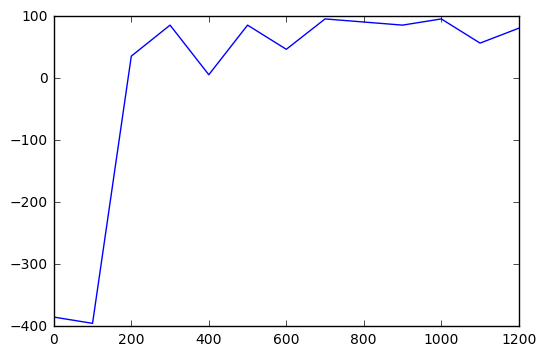

In [34]:
plt.plot(*zip(*sorted(list(rewards.items()),key=lambda p:p[0])))
    

In [35]:
action_layer.epsilon.set_value(0.001)
rw = pool.evaluate(n_games=20,save_path="./records",record_video=True)
print("mean session score=%f.5"%np.mean(rw))

[2017-01-14 11:57:26,613] Making new env: ppaquette/DoomBasic-v0
[2017-01-14 11:57:26,628] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-14 11:57:26,630] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-01-14 11:57:26,957] Starting new video recorder writing to /home/hedgedir/agentnet/examples/records/openaigym.video.14.2042.video000000.mp4
[2017-01-14 11:57:27,319] Starting new video recorder writing to /home/hedgedir/agentnet/examples/records/openaigym.video.14.2042.video000001.mp4


Episode finished after 3 timesteps with reward=86.0
Episode finished after 2 timesteps with reward=91.0
Episode finished after 4 timesteps with reward=81.0
Episode finished after 8 timesteps with reward=61.0
Episode finished after 4 timesteps with reward=81.0
Episode finished after 6 timesteps with reward=71.0


[2017-01-14 11:57:28,255] Starting new video recorder writing to /home/hedgedir/agentnet/examples/records/openaigym.video.14.2042.video000008.mp4


Episode finished after 6 timesteps with reward=71.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 6 timesteps with reward=71.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 3 timesteps with reward=86.0
Episode finished after 8 timesteps with reward=61.0
Episode finished after 4 timesteps with reward=81.0
Episode finished after 3 timesteps with reward=86.0
Episode finished after 1 timesteps with reward=96.0
Episode finished after 5 timesteps with reward=76.0
Episode finished after 11 timesteps with reward=38.0


[2017-01-14 11:57:29,840] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/hedgedir/agentnet/examples/records')


Episode finished after 7 timesteps with reward=66.0
mean session score=75.350000.5


In [36]:
from agentnet.utils.persistence import save,load
#save for display
save(action_layer,"doombasic_dqn_2500.pcl")

In [39]:
from IPython.display import HTML
import os
from random import choice
#select the one you want
videos = filter(lambda s:s.endswith(".mp4"),os.listdir("./records/"))
video_path="./records/"+choice(videos)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Once you got it working,
Try building a network that maximizes the final score

* Moar lasagne stuff: convolutional layers, batch normalization, nonlinearities and so on
* Recurrent agent memory layers, GRUMemoryLayer, etc
* Different reinforcement learning algorithm (p.e. qlearning_n_step), other parameters
* Experience replay pool


Look for info?
* [lasagne doc](http://lasagne.readthedocs.io/en/latest/)
* [agentnet doc](http://agentnet.readthedocs.io/en/latest/)
* [gym homepage](http://gym.openai.com/)


You can also try to expand to a different game: 
 * all OpenAI Atari games are already compatible, you only need to change GAME_TITLE
 * Other discrete action space environments are also accessible this way
 * For continuous action spaces, either discretize actions or use continuous RL algorithms (e.g. .learning.dpg_n_step)
 * Adapting to a custom non-OpenAI environment can be done with a simple wrapper
 
 
__Good luck!__